In [1]:
import tensorflow as tf

C:\Users\shiwa\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\shiwa\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\shiwa\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob

from tqdm import tqdm
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [5]:
train_dataset  = train_datagen.flow_from_directory(directory = '../mycode/Data/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 64)

Found 613 images belonging to 4 classes.


In [6]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../mycode/Data/valid',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 72 images belonging to 4 classes.


In [7]:
test_dataset = test_datagen.flow_from_directory(directory = '../mycode/Data/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 10)

Found 315 images belonging to 4 classes.


In [8]:
base_model = tf.keras.applications.EfficientNetB7(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [9]:
for layer in base_model.layers[:-8]:
    layer.trainable=False

In [10]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2560)        0         
                                                                 
 flatten (Flatten)           (None, 125440)            0         
                                                                 
 batch_normalization (BatchN  (None, 125440)           501760    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                4014112   
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [12]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image


In [13]:
pip install pydot

In [14]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [15]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [16]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=3, patience=3)

In [17]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [18]:
%time
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 100,verbose = 1,callbacks=[lrd,mcp,es])

Wall time: 0 ns
Epoch 1/100
10/10 [==============================] - 129s 10s/step - loss: 1.7409 - accuracy: 0.6978 - precision: 0.2355 - recall: 0.0930 - auc: 0.4731 - f1_score: 0.1325 - val_loss: 6.1839 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4449 - val_f1_score: 0.2656 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - 82s 8s/step - loss: 1.6620 - accuracy: 0.7002 - precision: 0.1919 - recall: 0.0620 - auc: 0.4753 - f1_score: 0.0932 - val_loss: 2.6439 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4580 - val_f1_score: 0.2656 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - 82s 8s/step - loss: 1.5372 - accuracy: 0.7280 - precision: 0.3071 - recall: 0.0701 - auc: 0.5123 - f1_score: 0.1090 - val_loss: 1.7538 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4886 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/100
10/10 [=====================

In [19]:
model.evaluate(test_dataset, verbose=1)

32/32 [==============================] - 41s 1s/step - loss: 1.3382 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6462 - f1_score: 0.0000e+00


[1.3381649255752563, 0.75, 0.0, 0.0, 0.6462047100067139, 0.0]

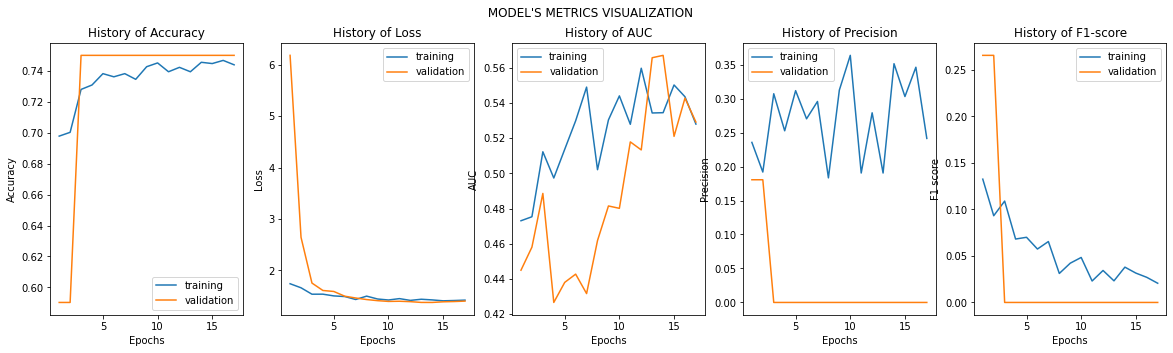

In [20]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [21]:
def chestScanPrediction(path, _model):
    classes_dir = ["Adenocarcinoma","Large cell carcinoma","Normal","Squamous cell carcinoma"]
    # Loading Image
    img = image.load_img(path, target_size=(224,224, 3))
    # Normalizing Image
    norm_img = image.img_to_array(img)/255
    # Converting Image to Numpy Array
    input_arr_img = np.array([norm_img])
    # Getting Predictions
    pred = np.argmax(_model.predict(input_arr_img))
    # Printing Model Prediction
    print(classes_dir[pred])

In [24]:
from tensorflow.keras.preprocessing import image
path = "../mycode/000138 (6).png"
chestScanPrediction(path,model)

Adenocarcinoma


In [25]:
jupyter nbconvert code2.ipynb --to python

SyntaxError: invalid syntax (<ipython-input-25-0fe2e6b54e47>, line 1)